# Sentiment analysis on IMDB reviews: TensorFlow GloVe and LSTM with Estimator APIs

This notebook represents more or less what was done with TF Estimators API with an LSTM based model on top of GloVe embedding on the 15.07.18 of my project. It is a stable version.

In this notebook I will try to perform sentiment analysis using TensorFlow. Most of the notebook is a variation of what was done on this blog:
https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

This is an upgrade of the previous notebook (IMDB_sent_an_TF_basic_improved1) where I'm replacing the basic APIs by custom Estimator level APIs. This includes in particular using `tf.estimator.Estimator` objects as well as `tf.data.Datasets` For this I follow the indications of these tutorials coming from the official documentation:

https://www.tensorflow.org/get_started/premade_estimators

https://www.tensorflow.org/get_started/datasets_quickstart

https://www.tensorflow.org/get_started/custom_estimators

## Libraries

In [1]:
import numpy as np
import csv
import io
import tensorflow as tf
#import datetime

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

There are different **word embedding sizes**. The possibilities are 50, 100, 200, 300. We define the one we use next. On my personal machine, 100 seems to be the upper limit. With 200, I get `ResourceExhaustedError`.

In [2]:
word_emb_size = '100'

In [3]:
emb_file_name = 'glove.6B/glove.6B.' + word_emb_size + 'd.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [4]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [5]:
emb_df.shape

(400000, 100)

Then we transform the Pandas data frame into one list `words_list` containing the words (the indexes from the data frame) and one numpy array `word_vectors` containing the corresponding vectors. This last data frame will play the role of our **look-up table** later when we define our model.

In [6]:
words_list = list(emb_df.index)
word_vectors = emb_df.values

## Examples with Embeddings

I commented this part because it is useless for the real task. It only serves a pedagogic purpose.

In [7]:
#baseball_idx = words_list.index('baseball')
#word_vectors[baseball_idx]

In [8]:
#max_seq_len = 10 #Maximum length of sentence

In [9]:
#first_sentence = np.zeros((max_seq_len), dtype='int32')
#first_sentence[0] = words_list.index("i")
#first_sentence[1] = words_list.index("thought")
#first_sentence[2] = words_list.index("the")
#first_sentence[3] = words_list.index("movie")
#first_sentence[4] = words_list.index("was")
#first_sentence[5] = words_list.index("incredible")
#first_sentence[6] = words_list.index("and")
#first_sentence[7] = words_list.index("inspiring")
##first_sentence[8] and first_sentence[9] are going to be 0
#print(first_sentence.shape)
#print(first_sentence) #Shows the row index for each word

In [10]:
#with tf.Session() as sess:
#    print(tf.nn.embedding_lookup(word_vectors,first_sentence).eval().shape)

## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text.

In [11]:
from os import listdir
from os.path import isfile, join

In [12]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

In [13]:
TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
pos_files_trn = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
neg_files_trn = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

In [14]:
TEST_POS = TEST + 'pos/'
TEST_NEG = TEST + 'neg/'
pos_files_test = [TEST_POS + f for f in listdir(TEST_POS) if isfile(join(TEST_POS, f))]
neg_files_test = [TEST_NEG + f for f in listdir(TEST_NEG) if isfile(join(TEST_NEG, f))]

Next we determine the average number of words in one sample of the training set.

In [15]:
n_words = []
for pf in pos_files_trn:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)       
print('Positive files finished')

for nf in neg_files_test:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        n_words.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


In [16]:
n_files_trn = len(pos_files_trn) + len(neg_files_trn)
n_files_test = len(pos_files_test) + len(neg_files_test)

Strangely it seems that there aren't exactly 12500 files in the folders indicated below, as it is supposed to be.

In [17]:
print(len(pos_files_trn))
print(len(neg_files_trn))
print(len(pos_files_test))
print(len(neg_files_test))

12501
12501
12501
12500


In [18]:
print('The total number of files is', n_files_trn)
print('The total number of words in the files is', sum(n_words))
print('The average number of words in the files is', sum(n_words)/len(n_words))

The total number of files is 25002
The total number of words in the files is 5809599
The average number of words in the files is 232.37466501339946


Next we plot an histogram of the number of words in each sample.

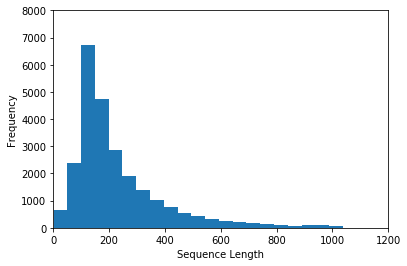

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(n_words, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 words seems a good choice.

In [20]:
max_seq_len = 250

## Mapping words to indexes

In this section we map words to indexes using our words_list variable.

First we do it for a specific file.

We display the content of the file (i.e. the real text).  (I commented out this part because it is useless for the real task)

In [21]:
#fname = pos_files_trn[3] #Can use any valid index (not just 3)
#with open(fname) as f:
#    for lines in f:
#        print(lines)
#        exit

Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [22]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

We map the given file to a list of indexes where each indexe corresponds to a word, according to the list `words_list`. (I commented out this part because it is useless for the real task)

In [23]:
#first_file = np.zeros((max_seq_len), dtype='int32')
#with open(fname) as f:
#    idx_counter = 0
#    line=f.readline()
#    cleaned_line = clean_sentences(line)
#    split = cleaned_line.split()
#    for word in split:
#        try:
#            first_file[idx_counter] = words_list.index(word)
#        except ValueError:
#            first_file[idx_counter] = 399999 #Vector for unknown words
#        idx_counter = idx_counter + 1
#first_file

### Training set

ids_train will be a matrix, which contains for each file of the training set (first the positive ones, then the negative ones) a row where the columns contain the indices corresponding to the words of the sample file.

The whole computation of the transformation of each text file into a list of indices takes time and needs to be performed only once. The result is saved after the first time and then reloaded for all the other executions.

In [24]:
#ids_train = np.zeros((n_files_trn, max_seq_len), dtype='int32')

In [25]:
#file_counter = 0
#for pf in pos_files_trn:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

In [26]:
#for nf in neg_files_trn:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_train[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_train[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

In [27]:
#Pass into embedding function and see if it evaluates. 

#np.save('idsMatrixTrain'+word_emb_size, ids_train)

ids_train = np.load('idsMatrixTrain'+word_emb_size+'.npy')

In [28]:
ids_train.shape

(25002, 250)

### Testing set

In [29]:
#ids_test = np.zeros((n_files_test, max_seq_len), dtype='int32')

In [30]:
#file_counter = 0
#for pf in pos_files_test:
#    with open(pf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1

In [31]:
#for nf in neg_files_test:
#    with open(nf, "r") as f:
#        idx_counter = 0
#        line=f.readline()
#        cleaned_line = clean_sentences(line)
#        split = cleaned_line.split()
#        for word in split:
#            try:
#                ids_test[file_counter][idx_counter] = words_list.index(word)
#            except ValueError:
#                ids_test[file_counter][idx_counter] = 399999 #Vector for unkown words
#            idx_counter = idx_counter + 1
#            if idx_counter >= max_seq_len:
#                break
#        file_counter = file_counter + 1 

In [32]:
#np.save('idsMatrixTest'+word_emb_size, ids_test)

ids_test = np.load('idsMatrixTest'+word_emb_size+'.npy')

## Labels

Now we also create the **labels** with **one-hot-encoding** ([1, 0] for positive and [0, 1] for negative), as done in the original notebook.

In [33]:
len_pos_trn = len(pos_files_trn)
len_neg_trn = len(neg_files_trn)
y_train = [[1,0] for i in range(len_pos_trn)] + [[0,1] for i in range(len_neg_trn)]

In [34]:
len_pos_test = len(pos_files_test)
len_neg_test = len(neg_files_test)
y_test = [[1,0] for i in range(len_pos_test)] + [[0,1] for i in range(len_neg_test)]

In [35]:
len_trn = len_pos_trn + len_neg_trn
len_test = len_pos_test + len_neg_test

It seems that some premade estimators do not accept one-hot-encoding of the labels as explained here:https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

For this reason I create a function which converts a list containing one-hot-incoded labels into a list containing **ordinal encoded** labels.

In [36]:
def onehot_2_ordinal(onehot):
    n_classes = len(onehot[0])
    ordinal = []
    for i in range(len(onehot)):
        for j in range(n_classes):
            if onehot[i][j]==1:
                ordinal.append(j)
    return(ordinal)

In [37]:
y_train_ord = onehot_2_ordinal(y_train)
y_test_ord = onehot_2_ordinal(y_test)

## Definition of the model

### Estimator APIs

In this section we create a model using the Estimator APIs from TF. One of the advantage of this higher level of APIs is that some things done manualy when using TF basic APIs, are done automatically. There is no need to initialize variables for instance, or defining writers for TensorBoard.

First we define the **input functions**. They are the objects which supply data for training, evaluating, and prediction to the model. They are using `tf.data.Dataset` objects which are one of the key tools of TF. These objects allow to access the data and manipulate it.

In the body of the next function, it is important that the argument of the `shuffle` method is equal to the length of the whole training data set. See entry of the 11.07.18 of my journal for details.

In [38]:
# features is a numpy array of shape (#samples, 250)
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(({'Indexes':features}, labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(len_trn).repeat().batch(batch_size)
    
    return dataset

In [39]:
# features is a numpy array of shape (#samples, 250)
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = {'Indexes':features}
    else:
        inputs = ({'Indexes':features}, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset

Next we define the **feature columns**:

In [40]:
my_feature_columns = []
my_feature_columns.append(tf.feature_column.numeric_column(key='Indexes', shape=max_seq_len))

Next we define the **directory where to store the log files for TensorBoard** as well as the checkpoint file, the model files, and the graph file. These last files enable the notebook to **automatically store and restaure** previously trained models (as long as the architecture is the same in the old and the new notebook), as explained in this tutorial:

https://www.tensorflow.org/guide/checkpoints

In [41]:
model_dir = '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_'+word_emb_size+'d/'

In order to define a custom estimator we need to define a **model function**. For this we mix the code of the notebook based only on basic TF APIs together with some parts of the script of this tutorial: https://www.tensorflow.org/get_started/custom_estimators

In [42]:
def my_model(features, labels, mode, params):
    # Use `input_layer` to apply the feature columns.
    input_data = tf.feature_column.input_layer(features, params['feature_columns'])
    # The next line is required because tf.feature_column.input_layer
    # outputs tf.float32 (whatever the input)
    # and tf.nn.embedding_lookup requires
    # tf.int32
    input_data = tf.cast(input_data, tf.int32)
    # Transform each index in a sentence into the associated vector
    data = tf.nn.embedding_lookup(word_vectors, input_data)
    # The following line is a fixe coming from this page:
    # https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/issues/2
    # in order to prevent an error appearing next.
    data = tf.cast(data, tf.float32)
    # Next we define the LSTM
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(params['lstm_units'])
    lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=params['keep_prob'])
    value, _ = tf.nn.dynamic_rnn(lstm_cell, data, dtype=tf.float32)
    # swaps the two first dimensions so it has dimensions [max_time, batch_size, cell.output_size]
    value = tf.transpose(value, [1, 0, 2])
    # If I'm not mistaken the next cell slices the part of 
    # the output which corresponds to the last output of the lstm, 
    # or in other words the output corresponding to the 
    # last word for every sample (if I'm right we used 
    # 0 padding and cut everything which goes beyound 250 words, 
    # so technically it is the 250th output). 
    # My guess is that last has dimensions [batch_size, cell.output_size] 
    # which we can then use to do matrix multiplication 
    # with weight which has dimensions [cell.output_size, numClasses] 
    # (remember that cell.output_size=lstm_units).
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    # We apply an affine transformation to get the logits
    #weight = tf.Variable(tf.truncated_normal([params['lstm_units'], params['n_classes']]))
    #bias = tf.Variable(tf.constant(0.1, shape=[params['n_classes']]))
    #logits = (tf.matmul(last, weight) + bias)
    logits = tf.layers.dense(inputs=last, units=2)
    # Maybe I could  replace this last part using tf.layers.dense:
    # https://www.tensorflow.org/api_docs/python/tf/layers/dense
    
    # The following lines are actually independent of the achitecture
    # of the model.
    
    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss
    
    # Note that because of this function, we have to
    # provide ordinaly encoded labels and not one-hot-encoded
    # labels, as explained on this page:
    # https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)
    
    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

Next we can define the **custom estimator**.

In [43]:
classifier = tf.estimator.Estimator(
        model_fn=my_model,
        model_dir=model_dir,
        params={
            'feature_columns': my_feature_columns,
            'n_classes': 2,
            'lstm_units': 64,
            'keep_prob': 0.7
        })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_task_type': 'worker', '_is_chief': True, '_model_dir': '/home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/', '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f30fd2bf7f0>, '_global_id_in_cluster': 0, '_service': None, '_log_step_count_steps': 100, '_task_id': 0, '_save_checkpoints_steps': None, '_master': '', '_tf_random_seed': None, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_session_config': None}


## Training and evaluation of the Estimator

In [44]:
batch_size = int(100)
train_steps = int(8000)

Now we can **train** our Estimator. Note that for the function `tf.losses.sparse_softmax_cross_entropy`, that we are using in the model function, requires the **label** to be **ordinaly encoded and not one-hot-encoded** as explained here:

https://stackoverflow.com/questions/48114258/tensorflow-estimator-number-of-classes-does-not-change

In [45]:
classifier.train(
    input_fn=lambda:train_input_fn(features=ids_train, labels=y_train_ord, batch_size=batch_size),
    steps=train_steps)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


/home/aritz/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/model.ckpt.
INFO:tensorflow:loss = 0.8403634, step = 0
INFO:tensorflow:global_step/sec: 5.75768
INFO:tensorflow:loss = 0.68872017, step = 100 (17.369 sec)
INFO:tensorflow:global_step/sec: 6.27479
INFO:tensorflow:loss = 0.7099755, step = 200 (15.937 sec)
INFO:tensorflow:global_step/sec: 6.48786
INFO:tensorflow:loss = 0.68436676, step = 300 (15.413 sec)
INFO:tensorflow:global_step/sec: 6.54203
INFO:tensorflow:loss = 0.6871506, step = 400 (15.286 sec)
INFO:tensorflow:global_step/sec: 6.51199
INFO:tensorflow:loss = 0.6914494, step = 500 (15.357 sec)
INFO:tensorflow:global_step/sec: 6.5306
INFO:tensorflow:loss = 0.6863657, step = 600 (15.312 sec)
INFO:tensorflow:global_step/sec: 6.55944
INFO:tensor

INFO:tensorflow:loss = 0.25588658, step = 7500 (16.586 sec)
INFO:tensorflow:global_step/sec: 6.27166
INFO:tensorflow:loss = 0.25691232, step = 7600 (15.944 sec)
INFO:tensorflow:global_step/sec: 6.26681
INFO:tensorflow:loss = 0.26699427, step = 7700 (15.957 sec)
INFO:tensorflow:global_step/sec: 6.23971
INFO:tensorflow:loss = 0.18709126, step = 7800 (16.027 sec)
INFO:tensorflow:global_step/sec: 6.28186
INFO:tensorflow:loss = 0.28253007, step = 7900 (15.919 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/model.ckpt.
INFO:tensorflow:Loss for final step: 0.35129797.


Now we can evaluate our model on the test data.

In [46]:
eval_test = classifier.evaluate(input_fn=lambda:eval_input_fn(features=ids_test,
                                                                    labels=y_test_ord,
                                                                    batch_size=batch_size)
                                     )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-15-10:44:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-07-15-10:44:51
INFO:tensorflow:Saving dict for global step 8000: accuracy = 0.8570057, global_step = 8000, loss = 0.3316556


Finally we print the **accuracy of the model on the test set**.

In [47]:
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_test))


Test set accuracy: 0.857



In [48]:
print(eval_test)

{'accuracy': 0.8570057, 'loss': 0.3316556, 'global_step': 8000}


## Long Training

In this section I will implement a loop which will train the model as long as the quality of the prediction keeps improving.

In [49]:
batch_size = int(100)
train_steps = int(1000)

In [54]:
acc_i = 0
acc_iplus1 = 0
acc_iplus2 = eval_test['accuracy']
num_iter = 0

In [55]:
while ((acc_iplus2 > acc_iplus1) or (acc_iplus2 > acc_i)):
    num_iter = num_iter + 1
    classifier.train(
    input_fn=lambda:train_input_fn(features=ids_train, labels=y_train_ord, batch_size=batch_size),
    steps=train_steps)
    acc_i = acc_iplus1
    acc_iplus1 = acc_iplus2
    eval_test = classifier.evaluate(input_fn=lambda:eval_input_fn(features=ids_test,
                                                                    labels=y_test_ord,
                                                                    batch_size=batch_size)
                                     )
    acc_iplus2 = eval_test['accuracy']
    

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


/home/aritz/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12001 into /home/aritz/Documents/CS_Programming_Machine_Learning/Projects/IMDB_sentiment_analysis/IMDB_sent_an_TF/Saved_models/Basic_LSTM_100d/model.ckpt.
INFO:tensorflow:loss = 0.116583526, step = 12000
INFO:tensorflow:global_step/sec: 5.52669
INFO:tensorflow:loss = 0.24673532, step = 12100 (18.095 sec)
INFO:tensorflow:global_step/sec: 5.42818
INFO:tensorflow:loss = 0.1551571, step = 12200 (18.423 sec)
INFO:tensorflow:global_step/sec: 5.73969
INFO:tensorflow:loss = 0.15166456, step = 12300 (17.423 sec)
INFO:tensorflow:global_step/sec: 6.5761
INFO:tensorflow:loss = 0.34310123, step = 12400 (15.206 sec)
INFO:tensorflow:global_step/sec: 6.50861
INFO:tensorflow:loss = 0.11865516, s

In [59]:
print(acc_i)
print(acc_iplus1)
print(acc_iplus2)

0.83672655
0.8407664
0.83468664


## TensorBoard

In order to track the progress of the model on TensorBoard it is enough to enter "tensorboard --logdir (...)" in a terminal with "(...)" replaced by the name of the directory where the event files are saved, and visiting http://localhost:6006/ with a browser.

With custom estimators it is enough to include lines like
`tf.summary.scalar('loss', loss)`
in the model function in order to track the quantities we are interested in. An event file for TensorBoard will be updated every 100 steps during the training with the `train` method (at least it is what I observe from my empirical experience), and a single event file measuring the state of the tracked variable will be written when calling the `evaluate`method. There is no need to define a writer with `tf.summary.FileWriter`.

**Caveat emptor:** This being said, I often ran into problems with TensorBoard. No files were being written, or only during the evaluation phase. Currently it seems to work as I described above, but I cannot garantee that what I described is absolutely true. I don't know yet how to specify the behaviour of an Estimator object when it comes to TensorBoard.

## Debugging

In the next cells I use TF basic APIs to access directly what is happening when I call the train method of my Estimator object. This allows me to understand source of errors and warnings.

In [ ]:
batch_size = int(100)
lstm_units = int(64)

We start by defining **two datasets**. One for the training and one for the testing:

In [ ]:
dataset_train = train_input_fn(features=ids_train, labels=y_train_ord, batch_size=batch_size)
dataset_test = eval_input_fn(features=ids_test, labels=y_test_ord, batch_size=batch_size)

Next we define the **reinitializable iterator**. Unlike One-shot iterators, they alow to switch from one dataset to another one. As explained here:
https://www.tensorflow.org/programmers_guide/datasets#creating_an_iterator, 
"A reinitializable iterator is defined by its structure. We could use the
 `output_types` and `output_shapes` properties of either `dataset_train`
 or `dataset_test` here, because they are compatible."


In [ ]:
iterator = tf.data.Iterator.from_structure(dataset_train.output_types,
                                           dataset_train.output_shapes)

In [ ]:
features, labels = iterator.get_next()

The next cell contains the model itself (this part is similar to what is found in the model function of the Estimator object).

In [ ]:
input_data = tf.feature_column.input_layer(features, my_feature_columns)
input_data = tf.cast(input_data, tf.int32)
data = tf.nn.embedding_lookup(word_vectors, input_data)
data = tf.cast(data, tf.float32)
lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstm_units)
lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=0.8)
value, _ = tf.nn.dynamic_rnn(lstm_cell, data, dtype=tf.float32)
value = tf.transpose(value, [1, 0, 2])

In [ ]:
print(value)

In [ ]:
last = tf.gather(value, int(value.get_shape()[0]) - 1)
#weight = tf.Variable(tf.truncated_normal([lstm_units, 2]))
#bias = tf.Variable(tf.constant(0.1, shape=(2,)))
#logits = (tf.matmul(last, weight) + bias)
logits = tf.layers.dense(inputs=last, units=2)
predicted_classes = tf.argmax(logits, 1)
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())

In [ ]:
tf.summary.scalar('accuracy', accuracy[1])
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

The next operation is required in order to use reinitializable iterators but not for simple one-shot iterator.

In [ ]:
init_op_train = iterator.make_initializer(dataset_train)
init_op_test = iterator.make_initializer(dataset_test)

In [ ]:
sess_debug = tf.InteractiveSession()
sess_debug.run(tf.global_variables_initializer())

For some reason it seems to be necessary to add the following line though it wasn't in the original script. Otherwise I optain a FailedPreconditionError.

In [ ]:
sess_debug.run(tf.local_variables_initializer())

In [ ]:
writer_train = tf.summary.FileWriter(model_dir+'Basic_log/Plot_train/', sess_debug.graph)
writer_test = tf.summary.FileWriter(model_dir+'Basic_log/Plot_test/', sess_debug.graph)

We do the **training** of the model.

In [ ]:
for j in range(15):
    print('Epoch {}'.format(j))
    # Initialize an iterator over the training dataset.
    sess_debug.run([init_op_train])
    print('Training')
    for i in range(100):
        sess_debug.run(train_op)
        if (i % 50 == 0):  
            summary, acc = sess_debug.run([merged, accuracy])
            print("Accuracy = {}".format(acc[1]))
            writer_train.add_summary(summary, j*100)
    
    print('Testing')
    # Initialize an iterator over the testing dataset.
    sess_debug.run(init_op_test)
    sess_debug.run(merged)
    summary, acc = sess_debug.run([merged, accuracy])
    print("Accuracy = {}".format(acc[1]))
    writer_test.add_summary(summary, j*100)

In [ ]:
writer_debug.close()